In [2]:
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [1]:
import sys,math,pdb,time,re
from pathlib import Path
sys.path.append(str(Path("./")))


import numpy as np
import matplotlib.pyplot as plt
import IPython.display as dspl

import torch

import torchvision
import torchvision.transforms as transforms

from utils import gadget_tb,nn_fn


torch.cuda.set_device('cuda:3')

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Lambda(lambda x:x.repeat(3,1,1)) ,
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
BATCH_SIZE = 64

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          pin_memory=True,persistent_workers=True,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                          pin_memory=True,persistent_workers=True,
                                         shuffle=False, num_workers=4)


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
for x,y in trainloader:
    break

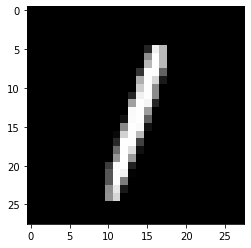

In [4]:
idx=2
plt.imshow(x[idx].numpy().transpose(1,2,0)/2+0.5)

In [6]:

model=nn_fn.ClasModel(3,10,latent_features=3,SoftMaxLayer=nn_fn.AddMarginProduct,s=15,m=0.01).cuda()
opt=torch.optim.Adam(model.parameters(),lr=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, 1*len(trainset)//BATCH_SIZE, 1)
# criterion=torch.nn.CrossEntropyLoss()
criterion=nn_fn.FocalLoss(3)

In [7]:
EPOCHS=50
weigh_norm=[]
latent_norm=[]
loss_mean_buff=[]
acc_mean_buff=[]
vloss_mean_buff=[]
vacc_mean_buff=[]

# now=re.sub('\W',"",time.ctime().replace(" ","_"))
# writer = gadget_tb.TBWriter(f'runs/exp-{now}')
writer = gadget_tb.TBWriter(f'runs/exp-add_margin')
word_display=dspl.display("",display_id=1)
plt.figure(figsize=(15,3))
try:
    for ee in range(EPOCHS):
        for ii,(x,y) in enumerate(trainloader):
            (x,y) = [t.cuda() for t in (x,y) if t is not None]
            opt.zero_grad()
            pred,hiddens =model(x,y)
            latent=hiddens[-1]
            loss = criterion(pred, y)
            acc=nn_fn.mean_acc(pred,y)

            loss.backward()
            opt.step()
            scheduler.step()
            
            with torch.no_grad():
                weigh_norm=torch.norm(model.softmax.weight,2).item()
                latent_norm=torch.norm(latent,2).item()
                loss_mean_buff=(loss_mean_buff*ii+loss.item())/(ii+1) if ii>0 else loss.item()
                acc_mean_buff=(acc_mean_buff*ii+acc)/(ii+1) if ii>0 else acc
                gadget_tb.show_progress(ee*len(trainloader)+ii,
                                        epoch=ee,session="train",
                                        loss=loss_mean_buff,acc=acc_mean_buff,
                                        weight=weigh_norm,latent=latent_norm)
        with torch.no_grad():
            for ii,(x,y) in enumerate(testloader):
                (x,y) = [t.cuda() for t in (x,y) if t is not None]
                opt.zero_grad()
                pred,hiddens =model(x,y)
                latent=hiddens[-1]
                loss = criterion(pred, y)
                acc=nn_fn.mean_acc(pred,y)
                
                vloss_mean_buff=(vloss_mean_buff*ii+loss.item())/(ii+1) if ii>0 else loss.item()
                vacc_mean_buff=(vacc_mean_buff*ii+acc)/(ii+1) if ii>0 else acc
                gadget_tb.show_progress(ee*len(trainloader)+ii,
                                        epoch=ee,session="val",
                                        loss=vloss_mean_buff,acc=vacc_mean_buff)
            
        writer.plt_once(loss=loss_mean_buff,acc=acc_mean_buff,val_loss=vloss_mean_buff,val_acc=vacc_mean_buff,
                     weight=weigh_norm,latent=latent_norm)  

    plt.clf()
except KeyboardInterrupt:
    print("User Stopped")
    plt.clf()

"['epoch:46', 'session:val', 'loss:0.0002', 'acc:0.9809']"

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


<Figure size 1080x216 with 0 Axes>

In [8]:
torch.save({'epoch': EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'loss': loss}, "checkpoint_add.pkl")

In [6]:
checkpoint = torch.load("checkpoint.pkl",map_location=next(model.parameters()).device)
model.load_state_dict(checkpoint['model_state_dict'])
opt.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [9]:
ee=46
word_display=dspl.display("",display_id=1)
testloader = torch.utils.data.DataLoader(testset, batch_size=512,
                                          pin_memory=True,persistent_workers=True,
                                         shuffle=False, num_workers=4)
for ii,(x,y) in enumerate(testloader):
    (x,y) = [t.cuda() for t in (x,y) if t is not None]
    opt.zero_grad()
    pred,hiddens =model(x,y)
    latent=hiddens[-1]
    loss = criterion(pred, y)
    acc=nn_fn.mean_acc(pred,y)

    vloss_mean_buff=(vloss_mean_buff*ii+loss.item())/(ii+1) if ii>0 else loss.item()
    vacc_mean_buff=(vacc_mean_buff*ii+acc)/(ii+1) if ii>0 else acc
    gadget_tb.show_progress(ee*len(trainloader)+ii,
                            epoch=ee,session="val",
                            loss=vloss_mean_buff,acc=vacc_mean_buff)

"['epoch:46', 'session:val', 'loss:0.0002', 'acc:0.9809']"

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


In [20]:
writer = gadget_tb.TBWriter(f'emb/exp_add')
writer.add_embedding(latent,label_img=x,metadata=y.detach().cpu().numpy())

In [7]:
N = 1000
data = np.random.normal(size=(N, 3))
data[:,0] *= 1
data[:,1] *= 1/3
data[:,2] *= 1/20
writer = gadget_tb.TBWriter(f'runs/exp-xx')
writer.add_embedding(data)

In [16]:
latent/latent.norm(dim=1,keepdim=True)

tensor([[-0.1774,  0.9840,  0.0137],
        [-0.9062, -0.3867, -0.1712],
        [-0.8652, -0.2195, -0.4509],
        [ 0.9553,  0.2276, -0.1884],
        [-0.4828,  0.5059, -0.7148],
        [ 0.3984,  0.6526, -0.6444],
        [ 0.9957, -0.0912, -0.0160],
        [-0.0356,  0.9966,  0.0749],
        [-0.9375, -0.3050, -0.1675],
        [ 0.0354, -0.8631,  0.5038],
        [-0.2104,  0.9772, -0.0276],
        [-0.5056,  0.4182,  0.7547],
        [ 0.4899,  0.7158, -0.4977],
        [ 0.6280,  0.6600, -0.4124],
        [ 0.7274,  0.0401, -0.6851],
        [ 0.9864,  0.0952,  0.1337],
        [-0.3589,  0.6987, -0.6188],
        [-0.0769,  0.9818,  0.1737],
        [ 0.9679,  0.0803,  0.2384],
        [ 0.0251, -0.4529, -0.8912],
        [-0.4341,  0.5127, -0.7408],
        [-0.4600, -0.6813, -0.5694],
        [ 0.6642, -0.1966, -0.7212],
        [ 0.3803,  0.5490,  0.7443],
        [ 0.4930,  0.5859,  0.6432],
        [-0.4020,  0.3137,  0.8602],
        [-0.7764, -0.2066, -0.5954],
 

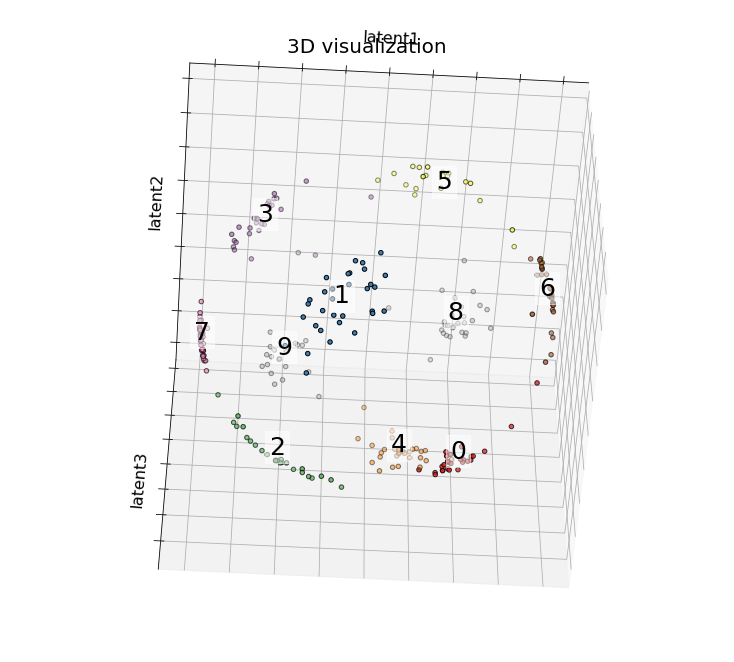

<Figure size 720x648 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib
def to_numpy(x: torch.Tensor)->np.array:
    return x.detach().cpu().numpy()

fig_display=dspl.display("",display_id=3)

t=np.linspace(-1,1,100)
ltn=latent/latent.norm(dim=-1,keepdim=True)
for t_elev,t_azim in zip(np.sin(t)*90,np.cos(t)*90):
    time.sleep(0.01)
    fig = plt.figure(1, figsize=(10, 9))
    ax = Axes3D(fig, elev=48+t_elev, azim=45+t_azim)
    ax.scatter(to_numpy(ltn[:, 0]),
               to_numpy(ltn[:, 1]),
               to_numpy(ltn[:, 2]),
               c=to_numpy(y),
               cmap=plt.cm.Set1, edgecolor='k')

    for label in range(10):
        ax.text3D(to_numpy(ltn[y == label, 0]).mean(),
                  to_numpy(ltn[y == label, 1]).mean(),
                  to_numpy(ltn[y == label, 2]).mean(), f"{label}",
                  horizontalalignment='center',
                  bbox=dict(alpha=.5, edgecolor='w', facecolor='w'),size=25)

    ax.set_title("3D visualization", fontsize=20)
    ax.set_xlabel("latent1", fontsize=16)
    ax.w_xaxis.set_ticklabels([])
    ax.set_ylabel("latent2", fontsize=16)
    ax.w_yaxis.set_ticklabels([])
    ax.set_zlabel("latent3", fontsize=16)
    ax.w_zaxis.set_ticklabels([])
    
    dspl.update_display(plt.gcf(),display_id=3)
    plt.clf()

In [ ]:
elev=48, azim=134

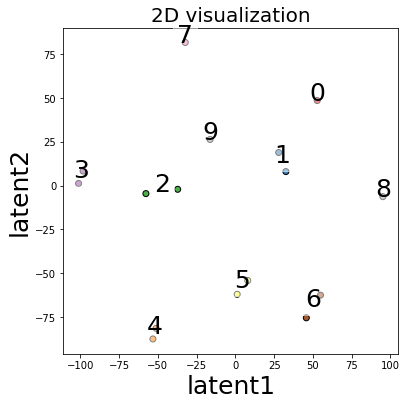

In [7]:

def to_numpy(x: torch.Tensor)->np.array:
    return x.detach().cpu().numpy()

fig = plt.figure(1, figsize=(6,6))
ax=plt.subplot(1,1,1)
ax.scatter(to_numpy(latent[:, 0]),
           to_numpy(latent[:, 1]),
           c=to_numpy(y),
           cmap=plt.cm.Set1, edgecolor='k')

for label in range(10):
    ax.text(to_numpy(latent[y == label, 0]).mean(),
              to_numpy(latent[y == label, 1]).mean(), f"{label}",
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'),size=25)

ax.set_title("2D visualization", fontsize=20)
ax.set_xlabel("latent1", fontsize=25)
ax.set_ylabel("latent2", fontsize=25)

plt.show()

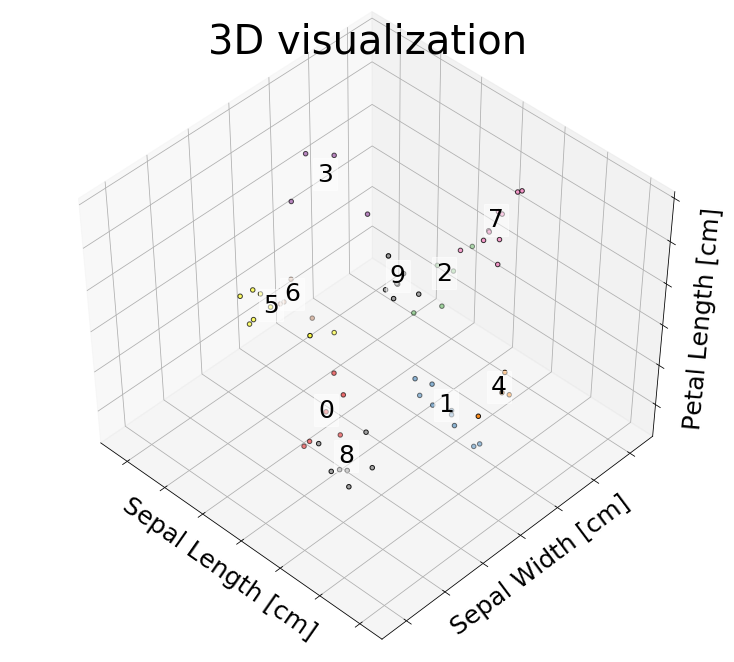

In [8]:

def to_numpy(x: torch.Tensor)->np.array:
    return x.detach().cpu().numpy()

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(10, 9))
ax = Axes3D(fig, elev=48, azim=134)
ax.scatter(to_numpy(latent[:, 0]),
           to_numpy(latent[:, 1]),
           to_numpy(latent[:, 2]),
           c=to_numpy(y),
           cmap=plt.cm.Set1, edgecolor='k')

for label in range(10):
    ax.text3D(to_numpy(latent[y == label, 0]).mean(),
              to_numpy(latent[y == label, 1]).mean(),
              to_numpy(latent[y == label, 2]).mean(), f"{label}",
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'),size=25)

ax.set_title("3D visualization", fontsize=40)
ax.set_xlabel("Sepal Length [cm]", fontsize=25)
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("Sepal Width [cm]", fontsize=25)
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("Petal Length [cm]", fontsize=25)
ax.w_zaxis.set_ticklabels([])

plt.show()

In [ ]:
ax.text

In [ ]:
ax.

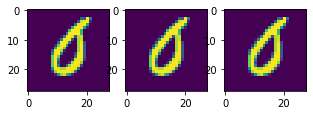

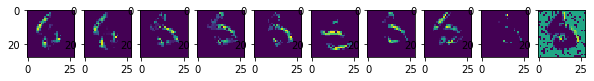

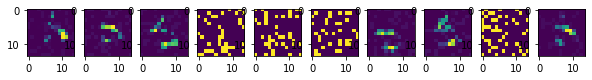

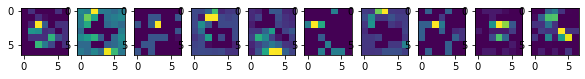

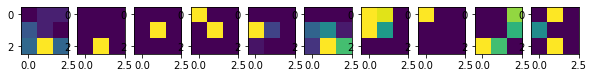

In [10]:
idx=0
N=4
plt.figure(figsize=(5,20))
for jj in range(3):
    
    plt.subplot(1,3,jj+1)
    plt.imshow(to_numpy(x[idx,jj,...]))
plt.show()

for ii in range(N):
    plt.figure(figsize=(10,25))
    for jj in range(10):
        plt.subplot(1,10,jj+1)
        plt.imshow(to_numpy(hiddens[ii][idx,jj,...]))
    plt.show()

In [14]:
[torch.norm(arg,2).item() for arg in hiddens]

[3686.10791015625,
 1001.7785034179688,
 500.91448974609375,
 214.431884765625,
 90.04277038574219,
 232.43345642089844]